In [1]:
###

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# load data
data = pd.read_csv('1_eda\in-vehicle-coupon-recommendation.csv')

In [37]:
# Display the first few rows of the dataset
data_head = data.head()

# Get the shape of the dataset
data_shape = data.shape

data_head, data_shape


(       destination  passanger weather  temperature  time  \
 0  No Urgent Place      Alone   Sunny           55   2PM   
 1  No Urgent Place  Friend(s)   Sunny           80  10AM   
 2  No Urgent Place  Friend(s)   Sunny           80  10AM   
 3  No Urgent Place  Friend(s)   Sunny           80   2PM   
 4  No Urgent Place  Friend(s)   Sunny           80   2PM   
 
                   coupon expiration  gender age      maritalStatus  ...  \
 0        Restaurant(<20)         1d  Female  21  Unmarried partner  ...   
 1           Coffee House         2h  Female  21  Unmarried partner  ...   
 2  Carry out & Take away         2h  Female  21  Unmarried partner  ...   
 3           Coffee House         2h  Female  21  Unmarried partner  ...   
 4           Coffee House         1d  Female  21  Unmarried partner  ...   
 
    CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
 0        never       NaN                  4~8              1~3   
 1        never       NaN               

In [39]:
# Basic statistics
data_description = data.describe(include='all')

data_description

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684,12684,12684,12684.000000,12684,12684,12684,12684,12684,12684,...,12467,12533,12554,12495,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
unique,3,4,3,NaN,5,5,2,2,8,5,...,5,5,5,5,NaN,NaN,NaN,NaN,NaN,NaN
top,No Urgent Place,Alone,Sunny,NaN,6PM,Coffee House,1d,Female,21,Married partner,...,less1,1~3,1~3,less1,NaN,NaN,NaN,NaN,NaN,NaN
freq,6283,7305,10069,NaN,3230,3996,7091,6511,2653,5100,...,3385,4672,5376,6077,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,63.301798,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,NaN,NaN,NaN,19.154486,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,NaN,NaN,NaN,30.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,NaN,NaN,NaN,80.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,NaN,NaN,NaN,80.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.000000,0.000000,0.000000,1.000000,1.000000


<AxesSubplot:xlabel='Y', ylabel='count'>

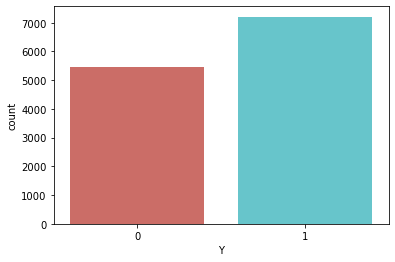

In [41]:
# Balance of the dataset
data['Y'].value_counts()

# graph
sns.countplot(x='Y', data=data, palette='hls')

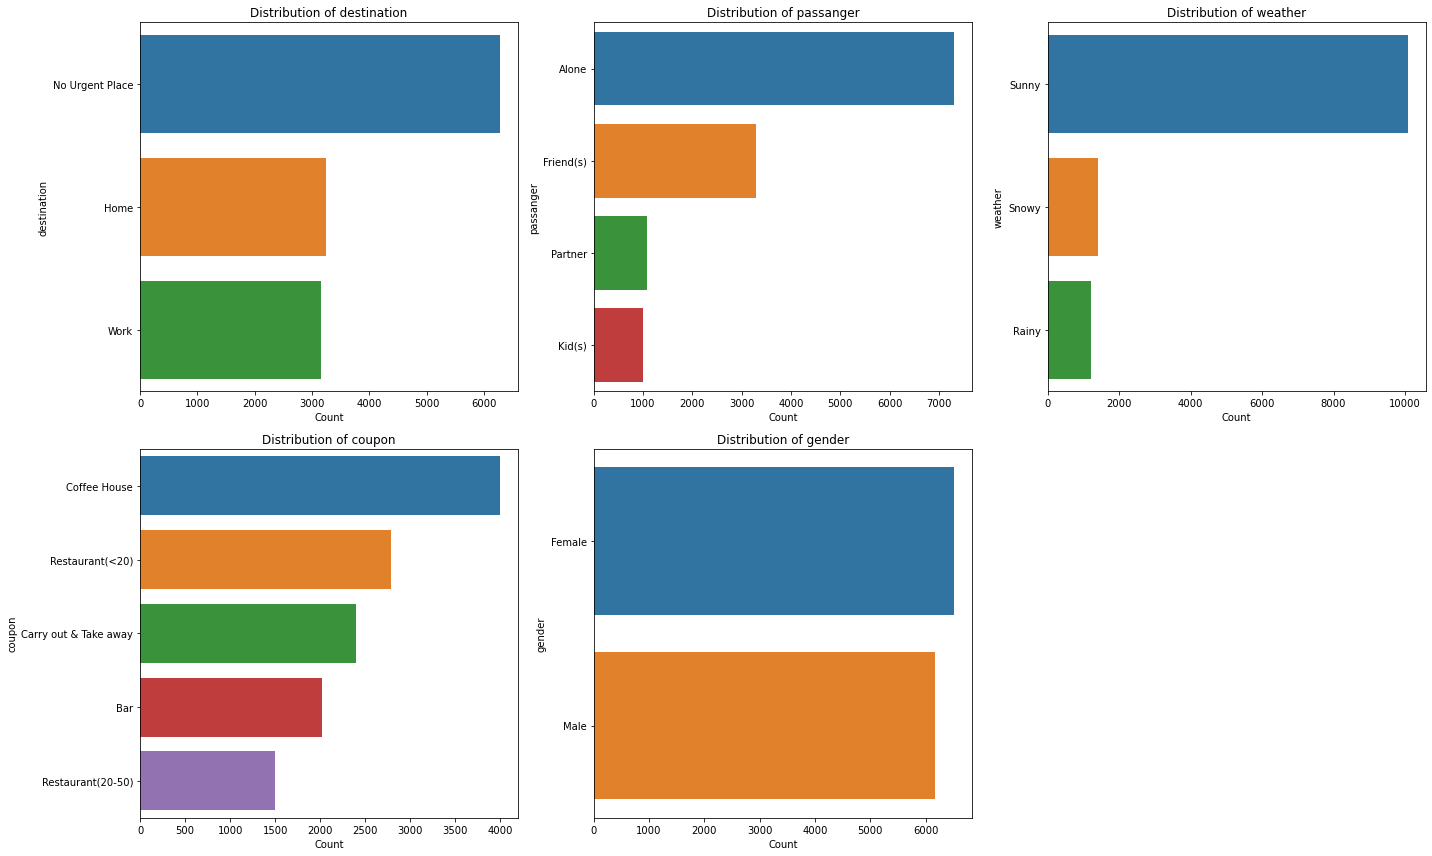

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to visualize
columns_to_visualize = ['destination', 'passanger', 'weather', 'coupon', 'gender']

plt.figure(figsize=(20, 12))

# Plotting the distribution of the selected columns
for i, column in enumerate(columns_to_visualize, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=data, y=column, order=data[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.tight_layout()

plt.show()


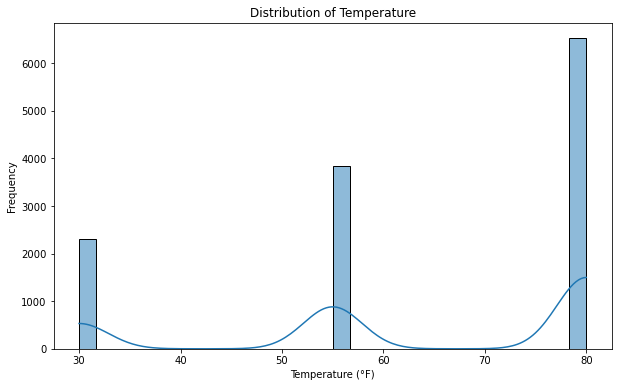

In [43]:
# Visualize the distribution of the 'temperature' column
plt.figure(figsize=(10, 6))
sns.histplot(data['temperature'], kde=True, bins=30)
plt.title('Distribution of Temperature')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()

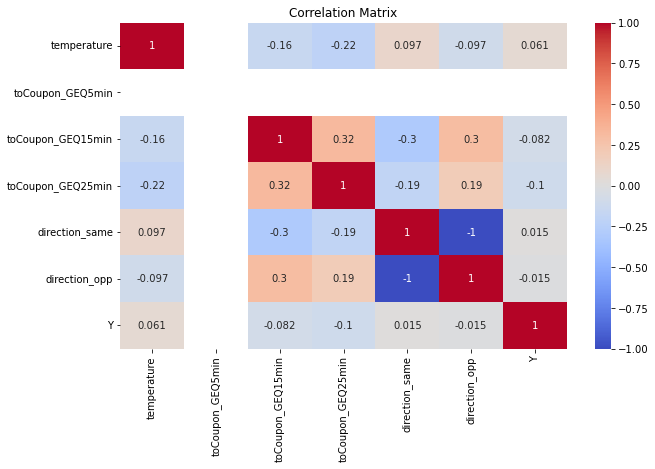

In [44]:
# List of numerical columns for correlation analysis
numerical_columns = ['temperature', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 
                     'direction_same', 'direction_opp', 'Y']

# Compute the correlation matrix
correlation_matrix = data[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Outliers e Fit distr.

### Outliers - Categorical
